# 🎬 Hybrid Movie Recommendation System

This notebook implements a hybrid movie recommendation system that combines:
1. **Matrix Factorization (PMF)** - Learns latent factors from user-item interactions
2. **BERT/Qwen Embeddings** - Captures semantic similarity from movie content

We compare multiple approaches:
- MF Only
- MF + MiniLM (Base & Fine-tuned)
- MF + Qwen3-Embedding-4B (Base & Fine-tuned with LoRA)

**Dataset**: MovieLens ml-latest-small (~100k ratings, ~9k movies, ~600 users)

**Requirements**: GPU needed for fine tuning

---
## 1️⃣ Setup & Installation

In [1]:
# Install required packages
!pip install -q cornac sentence-transformers pandas numpy scikit-learn matplotlib tqdm
!pip install -q peft accelerate bitsandbytes  # For LoRA fine-tuning

print("✅ Packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 32.2 MB/s eta 0:00:00
✅ Packages installed successfully!


In [2]:
# Download and extract MovieLens dataset
import os
import urllib.request
import zipfile

DATASET_URL = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
DATASET_DIR = "ml-latest-small"

if not os.path.exists(DATASET_DIR):
    print("📥 Downloading MovieLens dataset...")
    urllib.request.urlretrieve(DATASET_URL, "ml-latest-small.zip")

    print("📂 Extracting files...")
    with zipfile.ZipFile("ml-latest-small.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    os.remove("ml-latest-small.zip")
    print("✅ Dataset ready!")
else:
    print("✅ Dataset already exists!")

📥 Downloading MovieLens dataset...
📂 Extracting files...
✅ Dataset ready!


In [3]:
# Import all required libraries
import pandas as pd
import numpy as np
import pickle
import warnings
import random
import gc
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import torch

warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)

# Check GPU
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print("\n✅ Libraries imported!")

GPU available: True
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB

✅ Libraries imported!


In [4]:
# Load datasets
print("📊 Loading datasets...")

ratings_df = pd.read_csv(f"{DATASET_DIR}/ratings.csv")
movies_df = pd.read_csv(f"{DATASET_DIR}/movies.csv")
tags_df = pd.read_csv(f"{DATASET_DIR}/tags.csv")

print(f"✅ Loaded {len(ratings_df):,} ratings, {len(movies_df):,} movies, {len(tags_df):,} tags")

📊 Loading datasets...
✅ Loaded 100,836 ratings, 9,742 movies, 3,683 tags


---
## 2️⃣ Data Exploration

In [5]:
# Basic statistics
print("=" * 50)
print("📈 DATASET STATISTICS")
print("=" * 50)
print(f"Number of users:   {ratings_df['userId'].nunique():,}")
print(f"Number of movies:  {ratings_df['movieId'].nunique():,}")
print(f"Number of ratings: {len(ratings_df):,}")
print(f"Number of tags:    {len(tags_df):,}")
print(f"\nRating range: {ratings_df['rating'].min()} - {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"\nSparsity: {(1 - len(ratings_df) / (ratings_df['userId'].nunique() * ratings_df['movieId'].nunique())) * 100:.2f}%")

📈 DATASET STATISTICS
Number of users:   610
Number of movies:  9,724
Number of ratings: 100,836
Number of tags:    3,683

Rating range: 0.5 - 5.0
Average rating: 3.50

Sparsity: 98.30%


In [6]:
# Sample data
print("\n📋 SAMPLE DATA")
print("\n--- Ratings ---")
display(ratings_df.head())
print("\n--- Movies ---")
display(movies_df.head())
print("\n--- Tags ---")
display(tags_df.head())


📋 SAMPLE DATA

--- Ratings ---


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



--- Movies ---


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



--- Tags ---


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


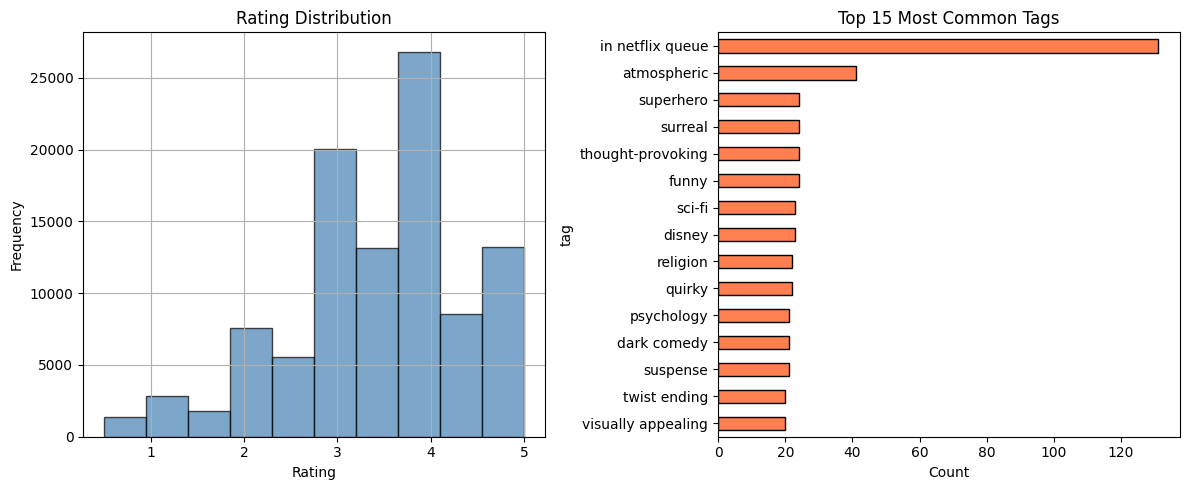

In [7]:
# Visualizations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ratings_df['rating'].hist(bins=10, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')

plt.subplot(1, 2, 2)
top_tags = tags_df['tag'].str.lower().value_counts().head(15)
top_tags.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Count')
plt.title('Top 15 Most Common Tags')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

---
## 3️⃣ Data Preprocessing

In [8]:
# Movie content with title + genres + tags
print("🔧 Creating movie content dictionary (with titles)...")

# Group tags by movieId
movie_tags = tags_df.groupby('movieId')['tag'].apply(
    lambda x: ' '.join(x.astype(str).str.lower())
).to_dict()

# Create content dictionary
movie_content = {}

for _, row in movies_df.iterrows():
    movie_id = row['movieId']

    # Get title (remove year in parentheses)
    title = row['title'].rsplit('(', 1)[0].strip()

    # Get genres
    genres = row['genres'].replace('|', ' ').replace('(no genres listed)', '')

    # Get tags
    tags = movie_tags.get(movie_id, '')

    # Combine: title + genres + tags
    content = f"{title} {genres} {tags}".strip()
    movie_content[movie_id] = content if content else "movie"

# Store movie IDs for later
movie_ids = list(movie_content.keys())

print(f"\n✅ Created content for {len(movie_content):,} movies")
print("\n📝 Examples:")
for mid in [1, 356, 318]:
    if mid in movie_content:
        title = movies_df[movies_df['movieId'] == mid]['title'].values[0]
        print(f"  {title}:")
        print(f"    → {movie_content[mid][:80]}...")

🔧 Creating movie content dictionary (with titles)...

✅ Created content for 9,742 movies

📝 Examples:
  Toy Story (1995):
    → Toy Story Adventure Animation Children Comedy Fantasy pixar pixar fun...
  Forrest Gump (1994):
    → Forrest Gump Comedy Drama Romance War shrimp vietnam bubba gump shrimp lieutenan...
  Shawshank Redemption, The (1994):
    → Shawshank Redemption, The Crime Drama prison stephen king wrongful imprisonment ...


In [9]:
# Random per-user split
print("🔀 Creating train/test split (random per-user)...")

train_list = []
test_list = []

for user_id, group in ratings_df.groupby('userId'):
    if len(group) >= 5:
        user_train, user_test = train_test_split(
            group, test_size=0.2, random_state=42
        )
        train_list.append(user_train)
        test_list.append(user_test)
    else:
        train_list.append(group)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# Verify
train_users = set(train_df['userId'])
test_users = set(test_df['userId'])
overlap = train_users & test_users

print(f"\n✅ Train set: {len(train_df):,} ratings")
print(f"✅ Test set:  {len(test_df):,} ratings")
print(f"\nUsers in training: {len(train_users)}")
print(f"Users in test: {len(test_users)}")
print(f"Users in BOTH (evaluable): {len(overlap)}")

🔀 Creating train/test split (random per-user)...

✅ Train set: 80,419 ratings
✅ Test set:  20,417 ratings

Users in training: 610
Users in test: 610
Users in BOTH (evaluable): 610


In [10]:
# Create ID mappings for Cornac
print("🔢 Creating ID mappings...")

unique_users = train_df['userId'].unique()
unique_items = train_df['movieId'].unique()

user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

print(f"✅ Mapped {len(user_to_idx)} users and {len(item_to_idx)} items")

🔢 Creating ID mappings...
✅ Mapped 610 users and 8965 items


---
## 4️⃣ Matrix Factorization (PMF)

In [11]:
# Prepare Cornac dataset
from cornac.data import Dataset
from cornac.models import PMF

print("📊 Preparing Cornac dataset...")

train_uir = [
    (user_to_idx[row['userId']], item_to_idx[row['movieId']], row['rating'])
    for _, row in train_df.iterrows()
]

train_set = Dataset.from_uir(train_uir, seed=42)
print(f"✅ Created dataset with {train_set.num_users} users and {train_set.num_items} items")

📊 Preparing Cornac dataset...
✅ Created dataset with 610 users and 8965 items


In [12]:
# Train PMF model
print("🚀 Training PMF model...")

mf_model = PMF(
    k=100,
    max_iter=200,
    learning_rate=0.005,
    lambda_reg=0.001,
    verbose=True,
    seed=42
)

mf_model.fit(train_set)
print("\n✅ PMF model trained!")

🚀 Training PMF model...
Learning...
epoch 0, loss: 4318.489977
epoch 1, loss: 3290.917700
epoch 2, loss: 2980.701666
epoch 3, loss: 2715.185973
epoch 4, loss: 2448.136548
epoch 5, loss: 2188.009673
epoch 6, loss: 1949.875283
epoch 7, loss: 1739.632892
epoch 8, loss: 1560.851726
epoch 9, loss: 1414.300459
epoch 10, loss: 1297.984274
epoch 11, loss: 1207.840314
epoch 12, loss: 1139.119642
epoch 13, loss: 1087.149330
epoch 14, loss: 1048.026970
epoch 15, loss: 1018.566331
epoch 16, loss: 996.253087
epoch 17, loss: 979.230850
epoch 18, loss: 966.137262
epoch 19, loss: 955.837762
epoch 20, loss: 947.702905
epoch 21, loss: 941.160534
epoch 22, loss: 935.706108
epoch 23, loss: 931.269719
epoch 24, loss: 927.420977
epoch 25, loss: 924.238107
epoch 26, loss: 921.388229
epoch 27, loss: 918.967406
epoch 28, loss: 916.801559
epoch 29, loss: 914.831494
epoch 30, loss: 913.134667
epoch 31, loss: 911.515991
epoch 32, loss: 910.145460
epoch 33, loss: 908.840901
epoch 34, loss: 907.716876
epoch 35, los

In [13]:
# Save MF model
print("💾 Saving MF model...")

with open('mf_model.pkl', 'wb') as f:
    pickle.dump({
        'model': mf_model,
        'user_to_idx': user_to_idx,
        'item_to_idx': item_to_idx,
        'idx_to_user': idx_to_user,
        'idx_to_item': idx_to_item,
        'train_set': train_set
    }, f)

print("✅ Saved to 'mf_model.pkl'")

💾 Saving MF model...
✅ Saved to 'mf_model.pkl'


---
## 5️⃣ MiniLM Embeddings (Base)

In [14]:
from sentence_transformers import SentenceTransformer

print("📥 Loading MiniLM model...")
minilm_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"✅ Loaded! Embedding dim: {minilm_model.get_sentence_embedding_dimension()}")

📥 Loading MiniLM model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded! Embedding dim: 384


In [15]:
# Generate MiniLM base embeddings
print("🧠 Generating MiniLM embeddings...")

movie_texts = [movie_content[mid] for mid in movie_ids]

minilm_base_array = minilm_model.encode(
    movie_texts,
    show_progress_bar=True,
    batch_size=64
)

minilm_base_embeddings = {mid: emb for mid, emb in zip(movie_ids, minilm_base_array)}

print(f"\n✅ Generated embeddings for {len(minilm_base_embeddings)} movies")

with open('minilm_base_embeddings.pkl', 'wb') as f:
    pickle.dump(minilm_base_embeddings, f)
print("💾 Saved to 'minilm_base_embeddings.pkl'")

🧠 Generating MiniLM embeddings...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]


✅ Generated embeddings for 9742 movies
💾 Saved to 'minilm_base_embeddings.pkl'


---
## 6️⃣ MiniLM Fine-tuning

In [16]:
# Create training pairs from user interactions
print("📊 Creating positive pairs from user interactions...")

user_liked_movies = train_df[train_df['rating'] >= 4.0].groupby('userId')['movieId'].apply(list).to_dict()

positive_pairs = []
for user_id, liked_movies in tqdm(user_liked_movies.items(), desc="Processing users"):
    if len(liked_movies) < 5:
        continue

    movie_pairs = list(combinations(liked_movies, 2))
    if len(movie_pairs) > 10:
        movie_pairs = random.sample(movie_pairs, 10)

    for movie_a, movie_b in movie_pairs:
        if movie_a in movie_content and movie_b in movie_content:
            positive_pairs.append((movie_content[movie_a], movie_content[movie_b]))

if len(positive_pairs) > 10000:
    positive_pairs = random.sample(positive_pairs, 10000)

print(f"\n✅ Created {len(positive_pairs):,} positive pairs")

📊 Creating positive pairs from user interactions...


Processing users: 100%|██████████| 609/609 [00:00<00:00, 1884.44it/s]


✅ Created 5,970 positive pairs


In [19]:
# Fine-tune MiniLM
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader
import os
import shutil

os.environ["WANDB_DISABLED"] = "true"
print("🎯 Fine-tuning MiniLM...")

minilm_finetune = SentenceTransformer('all-MiniLM-L6-v2')

train_examples = [InputExample(texts=[t1, t2]) for t1, t2 in positive_pairs]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(minilm_finetune)

minilm_finetune.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=2,
    warmup_steps=100,
    show_progress_bar=True
)

print("\n✅ Fine-tuning complete!")

🎯 Fine-tuning MiniLM...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,2.893800



✅ Fine-tuning complete!


In [22]:
save_path = "fine_tuned_minilm"

# Save the model
minilm_finetune.save(save_path)

shutil.make_archive(base_name=save_path, format='zip', root_dir=save_path)

print(f"✅ Model saved successfully to {save_path}")

✅ Model saved successfully to fine_tuned_minilm


In [23]:
# Generate fine-tuned MiniLM embeddings
print("🧠 Generating fine-tuned MiniLM embeddings...")

minilm_ft_array = minilm_finetune.encode(
    movie_texts,
    show_progress_bar=True,
    batch_size=64
)

minilm_finetuned_embeddings = {mid: emb for mid, emb in zip(movie_ids, minilm_ft_array)}

with open('minilm_finetuned_embeddings.pkl', 'wb') as f:
    pickle.dump(minilm_finetuned_embeddings, f)
print("💾 Saved to 'minilm_finetuned_embeddings.pkl'")

🧠 Generating fine-tuned MiniLM embeddings...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

💾 Saved to 'minilm_finetuned_embeddings.pkl'


---
## 7️⃣ Qwen3-Embedding-4B (Base)

In [24]:
# Clear memory before loading large model
gc.collect()
torch.cuda.empty_cache()

print("📥 Loading Qwen3-Embedding-4B...")
print("   This is a large model, may take a few minutes...")

qwen_model = SentenceTransformer(
    'Qwen/Qwen3-Embedding-4B',
    trust_remote_code=True,
    model_kwargs={"torch_dtype": torch.float16}
)

print(f"\n✅ Loaded! Embedding dim: {qwen_model.get_sentence_embedding_dimension()}")

📥 Loading Qwen3-Embedding-4B...
   This is a large model, may take a few minutes...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]


✅ Loaded! Embedding dim: 2560


In [25]:
# Helper function for memory-efficient encoding
def encode_in_chunks(model, texts, chunk_size=500, batch_size=8):
    """Encode texts in chunks to avoid OOM."""
    all_embeddings = []

    for i in tqdm(range(0, len(texts), chunk_size), desc="Encoding chunks"):
        chunk = texts[i:i+chunk_size]
        embeddings = model.encode(
            chunk,
            batch_size=batch_size,
            normalize_embeddings=True,
            show_progress_bar=False
        )
        all_embeddings.append(embeddings)
        torch.cuda.empty_cache()

    return np.vstack(all_embeddings)

In [26]:
# Generate Qwen base embeddings
print("🧠 Generating Qwen3-Embedding-4B embeddings...")
print("   This will take several minutes...")

qwen_base_array = encode_in_chunks(qwen_model, movie_texts, chunk_size=500, batch_size=8)

qwen_base_embeddings = {mid: emb for mid, emb in zip(movie_ids, qwen_base_array)}

print(f"\n✅ Generated embeddings for {len(qwen_base_embeddings)} movies")

with open('qwen_base_embeddings.pkl', 'wb') as f:
    pickle.dump(qwen_base_embeddings, f)
print("💾 Saved to 'qwen_base_embeddings.pkl'")

🧠 Generating Qwen3-Embedding-4B embeddings...
   This will take several minutes...


Encoding chunks: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


✅ Generated embeddings for 9742 movies
💾 Saved to 'qwen_base_embeddings.pkl'


---
## 8️⃣ Qwen3-Embedding-4B Fine-tuning (LoRA)

Fine-tuning a 4B parameter model requires LoRA (Low-Rank Adaptation) to fit in memory.

In [27]:
# Clear memory
del qwen_model
gc.collect()
torch.cuda.empty_cache()

print("📥 Loading Qwen3 for LoRA fine-tuning...")

from peft import LoraConfig, get_peft_model, TaskType

# Load with 4-bit quantization
qwen_finetune_model = SentenceTransformer(
    'Qwen/Qwen3-Embedding-4B',
    trust_remote_code=True,
    model_kwargs={
        "torch_dtype": torch.float16,
        "load_in_4bit": True,
    }
)

print("✅ Model loaded with 4-bit quantization")

📥 Loading Qwen3 for LoRA fine-tuning...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model loaded with 4-bit quantization


In [28]:
# Apply LoRA adapters
print("🔧 Applying LoRA adapters...")

try:
    base_model = qwen_finetune_model._first_module().auto_model

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION
    )

    peft_model = get_peft_model(base_model, lora_config)
    peft_model.print_trainable_parameters()
    qwen_finetune_model._first_module().auto_model = peft_model
    print("✅ LoRA adapters applied!")
    LORA_AVAILABLE = True
except Exception as e:
    print(f"⚠️ LoRA setup failed: {e}")
    print("   Will use regular fine-tuning with smaller batch size...")
    LORA_AVAILABLE = False

🔧 Applying LoRA adapters...
trainable params: 5,898,240 || all params: 4,027,672,576 || trainable%: 0.1464
✅ LoRA adapters applied!


In [29]:
# Fine-tune Qwen
print("🎯 Fine-tuning Qwen3...")

train_examples = [InputExample(texts=[t1, t2]) for t1, t2 in positive_pairs]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=4)  # Small batch
train_loss = losses.MultipleNegativesRankingLoss(qwen_finetune_model)

try:
    qwen_finetune_model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=2,
        warmup_steps=50,
        show_progress_bar=True
    )
    print("\n✅ Qwen fine-tuning complete!")
    QWEN_FINETUNED = True
except Exception as e:
    print(f"\n⚠️ Fine-tuning failed: {e}")
    print("   Will use base Qwen embeddings only.")
    QWEN_FINETUNED = False

🎯 Fine-tuning Qwen3...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,1.468800
1000,1.340500
1500,1.328000
2000,1.291600
2500,1.305600



✅ Qwen fine-tuning complete!


In [30]:
import shutil

lora_save_path = "qwen_lora_adapters_v1"

# 1. Access the PEFT model inside the SentenceTransformer wrapper
peft_model_wrapper = qwen_finetune_model._first_module().auto_model

# 2. Save only the adapter weights and config
peft_model_wrapper.save_pretrained(lora_save_path)

shutil.make_archive(base_name=lora_save_path, format='zip', root_dir=lora_save_path)

print(f"✅ LoRA adapters saved to {lora_save_path}")

✅ LoRA adapters saved to qwen_lora_adapters_v1


In [31]:
# Generate fine-tuned Qwen embeddings
if QWEN_FINETUNED:
    print("🧠 Generating fine-tuned Qwen embeddings...")

    qwen_ft_array = encode_in_chunks(qwen_finetune_model, movie_texts, chunk_size=500, batch_size=4)
    qwen_finetuned_embeddings = {mid: emb for mid, emb in zip(movie_ids, qwen_ft_array)}

    with open('qwen_finetuned_embeddings.pkl', 'wb') as f:
        pickle.dump(qwen_finetuned_embeddings, f)
    print("💾 Saved to 'qwen_finetuned_embeddings.pkl'")
else:
    # Use base embeddings as fallback
    qwen_finetuned_embeddings = qwen_base_embeddings
    print("⚠️ Using base Qwen embeddings as fallback")

🧠 Generating fine-tuned Qwen embeddings...


Encoding chunks: 100%|██████████| 20/20 [05:24<00:00, 16.22s/it]

💾 Saved to 'qwen_finetuned_embeddings.pkl'


---
## 9️⃣ Recommendation Functions

In [32]:
# Helper functions
def get_user_rated_items(user_id):
    """Get set of movie IDs that a user has rated in training data."""
    return set(train_df[train_df['userId'] == user_id]['movieId'].values)


def normalize_scores(scores):
    """Min-max normalize scores to [0, 1] range."""
    if len(scores) == 0:
        return scores
    min_score = min(scores.values())
    max_score = max(scores.values())
    if max_score == min_score:
        return {k: 0.5 for k in scores}
    return {k: (v - min_score) / (max_score - min_score) for k, v in scores.items()}

In [33]:
def recommend_mf_only(user_id, n=10):
    """
    Get top-N recommendations using Matrix Factorization only.
    """
    if user_id not in user_to_idx:
        return []

    user_idx = user_to_idx[user_id]

    if user_idx >= train_set.num_users:
        return []

    rated_items = get_user_rated_items(user_id)
    all_scores = mf_model.score(user_idx)

    candidates = []
    for item_idx in range(len(all_scores)):
        if item_idx in idx_to_item:
            movie_id = idx_to_item[item_idx]
            if movie_id not in rated_items:
                candidates.append((movie_id, float(all_scores[item_idx])))

    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[:n]

In [34]:
def recommend_hybrid(user_id, embeddings_dict, n=10, alpha=0.85):
    """
    Get top-N recommendations using hybrid MF + content-based approach.
    Uses vectorized cosine similarity for speed.

    Args:
        user_id: Original user ID
        embeddings_dict: Dictionary of movie_id -> embedding vector
        n: Number of recommendations to return
        alpha: Weight for MF score (1-alpha for content similarity)
    """
    if user_id not in user_to_idx:
        return []

    user_idx = user_to_idx[user_id]
    rated_items = get_user_rated_items(user_id)

    user_ratings = train_df[train_df['userId'] == user_id][['movieId', 'timestamp', 'rating']].copy()

    if len(user_ratings) == 0:
        return recommend_mf_only(user_id, n)

    # Recency weights
    min_ts = user_ratings['timestamp'].min()
    max_ts = user_ratings['timestamp'].max()
    if max_ts > min_ts:
        user_ratings['norm_ts'] = (user_ratings['timestamp'] - min_ts) / (max_ts - min_ts)
    else:
        user_ratings['norm_ts'] = 1.0
    user_ratings['weight'] = np.exp(user_ratings['norm_ts']) * (user_ratings['rating'] / 5.0)

    # MF scores
    all_mf_scores = mf_model.score(user_idx)
    mf_scores = {idx_to_item[i]: s for i, s in enumerate(all_mf_scores) if i in idx_to_item}
    mf_scores_norm = normalize_scores(mf_scores)

    # Build rated items matrix
    rated_embeddings = []
    weights = []
    for _, row in user_ratings.iterrows():
        movie_id = row['movieId']
        if movie_id in embeddings_dict:
            rated_embeddings.append(embeddings_dict[movie_id])
            weights.append(row['weight'])

    if len(rated_embeddings) == 0:
        return recommend_mf_only(user_id, n)

    rated_matrix = np.vstack(rated_embeddings)
    weights = np.array(weights)

    # Build candidate items matrix
    candidate_ids = []
    candidate_embeddings = []
    for movie_id in mf_scores.keys():
        if movie_id not in rated_items and movie_id in embeddings_dict:
            candidate_ids.append(movie_id)
            candidate_embeddings.append(embeddings_dict[movie_id])

    if len(candidate_embeddings) == 0:
        return recommend_mf_only(user_id, n)

    candidate_matrix = np.vstack(candidate_embeddings)

    # Vectorized cosine similarity
    all_similarities = cosine_similarity(candidate_matrix, rated_matrix)
    weighted_sims = all_similarities @ weights
    content_scores = weighted_sims / weights.sum()

    content_scores_dict = {mid: score for mid, score in zip(candidate_ids, content_scores)}
    content_scores_norm = normalize_scores(content_scores_dict)

    # Combine scores
    final_scores = []
    for movie_id in content_scores_norm.keys():
        mf_score = mf_scores_norm.get(movie_id, 0)
        content_score = content_scores_norm.get(movie_id, 0)
        final_score = alpha * mf_score + (1 - alpha) * content_score
        final_scores.append((movie_id, final_score))

    final_scores.sort(key=lambda x: x[1], reverse=True)
    return final_scores[:n]

In [35]:
# Test recommendation functions
print("🧪 Testing recommendation functions...\n")

sample_user = train_df['userId'].value_counts().index[0]
print(f"Testing with user {sample_user}")
print(f"This user has rated {len(get_user_rated_items(sample_user))} movies\n")

mf_recs = recommend_mf_only(sample_user, n=5)
print("MF Only:")
for movie_id, score in mf_recs:
    title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print(f"  {title}: {score:.3f}")

hybrid_recs = recommend_hybrid(sample_user, qwen_base_embeddings, n=5)
print("\nHybrid (Qwen Base):")
for movie_id, score in hybrid_recs:
    title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print(f"  {title}: {score:.3f}")

🧪 Testing recommendation functions...

Testing with user 414
This user has rated 2158 movies

MF Only:
  Double Indemnity (1944): 2.261
  Miller's Crossing (1990): 2.252
  Apocalypse Now (1979): 2.221
  Hustler, The (1961): 2.188
  Three Colors: Red (Trois couleurs: Rouge) (1994): 2.171

Hybrid (Qwen Base):
  Double Indemnity (1944): 0.788
  Apocalypse Now (1979): 0.786
  Three Colors: Red (Trois couleurs: Rouge) (1994): 0.779
  Miller's Crossing (1990): 0.776
  Solaris (Solyaris) (1972): 0.771


---
## 🔟 Evaluation

In [36]:
def calculate_ndcg(recommended_items, ground_truth, k=10):
    """Calculate NDCG@K."""
    relevance = [1 if item in ground_truth else 0 for item in recommended_items[:k]]
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    ideal_relevance = sorted(relevance, reverse=True)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    return dcg / idcg if idcg > 0 else 0.0


def evaluate_recommender(recommend_func, test_df, embeddings=None, k=10, alpha=0.85):
    """Evaluate a recommendation function on test data."""
    precision_scores = []
    recall_scores = []
    ndcg_scores = []

    recommendable_items = set(item_to_idx.keys())
    test_users = test_df['userId'].unique()
    valid_users = [u for u in test_users if u in user_to_idx]

    skipped = 0
    total_hits = 0

    for user_id in tqdm(valid_users, desc="Evaluating users"):
        user_test = test_df[(test_df['userId'] == user_id) & (test_df['rating'] >= 4.0)]
        ground_truth = set(user_test['movieId'].values) & recommendable_items

        if len(ground_truth) == 0:
            skipped += 1
            continue

        if embeddings is not None:
            recs = recommend_func(user_id, embeddings, n=k, alpha=alpha)
        else:
            recs = recommend_func(user_id, n=k)

        if len(recs) == 0:
            continue

        recommended_items = [item_id for item_id, _ in recs]
        hits = len(set(recommended_items) & ground_truth)
        total_hits += hits

        precision_scores.append(hits / k)
        recall_scores.append(hits / len(ground_truth))
        ndcg_scores.append(calculate_ndcg(recommended_items, ground_truth, k))

    print(f"\n  Evaluated: {len(precision_scores)} users")
    print(f"  Skipped (no valid GT): {skipped}")
    print(f"  Total hits: {total_hits}")

    return {
        'precision': np.mean(precision_scores) if precision_scores else 0,
        'recall': np.mean(recall_scores) if recall_scores else 0,
        'ndcg': np.mean(ndcg_scores) if ndcg_scores else 0,
        'num_users': len(precision_scores)
    }

In [37]:
# Evaluate all methods
print("📊 Evaluating all methods...\n")

# MF Only
print("1/5: MF Only")
mf_results = evaluate_recommender(recommend_mf_only, test_df, embeddings=None, k=25)

# MiniLM Base
print("\n2/5: MF + MiniLM Base")
minilm_base_results = evaluate_recommender(recommend_hybrid, test_df,
                                            embeddings=minilm_base_embeddings, k=25, alpha=0.85)

# MiniLM Fine-tuned
print("\n3/5: MF + MiniLM Fine-tuned")
minilm_ft_results = evaluate_recommender(recommend_hybrid, test_df,
                                          embeddings=minilm_finetuned_embeddings, k=25, alpha=0.85)

# Qwen Base
print("\n4/5: MF + Qwen3-4B Base")
qwen_base_results = evaluate_recommender(recommend_hybrid, test_df,
                                          embeddings=qwen_base_embeddings, k=25, alpha=0.85)

# Qwen Fine-tuned
print("\n5/5: MF + Qwen3-4B Fine-tuned")
qwen_ft_results = evaluate_recommender(recommend_hybrid, test_df,
                                        embeddings=qwen_finetuned_embeddings, k=25, alpha=0.85)

print("\n✅ Evaluation complete!")

📊 Evaluating all methods...

1/5: MF Only


Evaluating users: 100%|██████████| 610/610 [00:06<00:00, 88.21it/s]



  Evaluated: 600 users
  Skipped (no valid GT): 10
  Total hits: 739

2/5: MF + MiniLM Base


Evaluating users: 100%|██████████| 610/610 [00:55<00:00, 11.03it/s]



  Evaluated: 600 users
  Skipped (no valid GT): 10
  Total hits: 712

3/5: MF + MiniLM Fine-tuned


Evaluating users: 100%|██████████| 610/610 [00:55<00:00, 11.06it/s]



  Evaluated: 600 users
  Skipped (no valid GT): 10
  Total hits: 735

4/5: MF + Qwen3-4B Base


Evaluating users: 100%|██████████| 610/610 [04:02<00:00,  2.52it/s]



  Evaluated: 600 users
  Skipped (no valid GT): 10
  Total hits: 762

5/5: MF + Qwen3-4B Fine-tuned


Evaluating users: 100%|██████████| 610/610 [04:02<00:00,  2.51it/s]


  Evaluated: 600 users
  Skipped (no valid GT): 10
  Total hits: 832

✅ Evaluation complete!


In [ ]:
# Display results table
print("\n" + "=" * 80)
print("📈 EVALUATION RESULTS")
print("=" * 80)
print(f"{'Method':<30} {'Precision@25':>15} {'Recall@25':>12} {'NDCG@25':>12}")
print("-" * 80)
print(f"{'MF Only':<30} {mf_results['precision']:>15.4f} {mf_results['recall']:>12.4f} {mf_results['ndcg']:>12.4f}")
print(f"{'MF + MiniLM (Base)':<30} {minilm_base_results['precision']:>15.4f} {minilm_base_results['recall']:>12.4f} {minilm_base_results['ndcg']:>12.4f}")
print(f"{'MF + MiniLM (Fine-tuned)':<30} {minilm_ft_results['precision']:>15.4f} {minilm_ft_results['recall']:>12.4f} {minilm_ft_results['ndcg']:>12.4f}")
print(f"{'MF + Qwen3-4B (Base)':<30} {qwen_base_results['precision']:>15.4f} {qwen_base_results['recall']:>12.4f} {qwen_base_results['ndcg']:>12.4f}")
print(f"{'MF + Qwen3-4B (Fine-tuned)':<30} {qwen_ft_results['precision']:>15.4f} {qwen_ft_results['recall']:>12.4f} {qwen_ft_results['ndcg']:>12.4f}")
print("=" * 80)

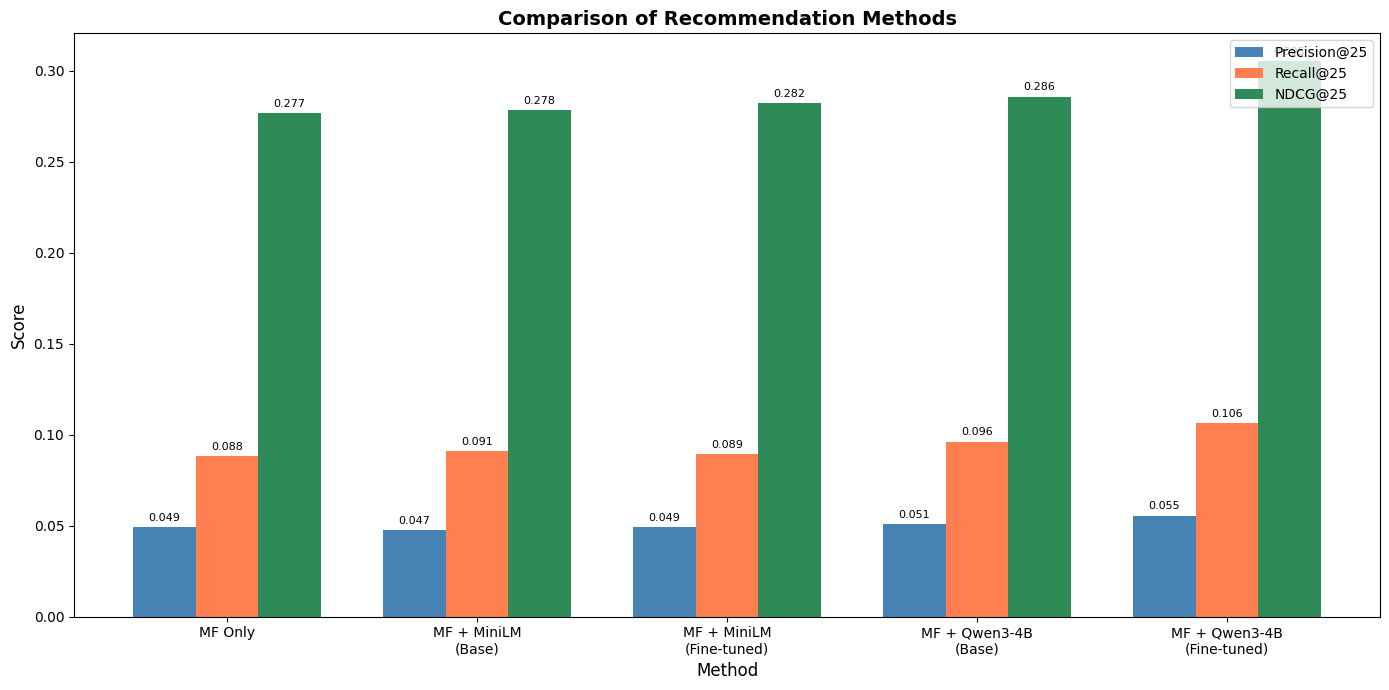


📊 Chart saved as 'final_comparison.png'


In [43]:
# Create comparison chart
methods = ['MF Only', 'MF + MiniLM\n(Base)', 'MF + MiniLM\n(Fine-tuned)',
           'MF + Qwen3-4B\n(Base)', 'MF + Qwen3-4B\n(Fine-tuned)']

precision_values = [mf_results['precision'], minilm_base_results['precision'],
                    minilm_ft_results['precision'], qwen_base_results['precision'],
                    qwen_ft_results['precision']]
recall_values = [mf_results['recall'], minilm_base_results['recall'],
                 minilm_ft_results['recall'], qwen_base_results['recall'],
                 qwen_ft_results['recall']]
ndcg_values = [mf_results['ndcg'], minilm_base_results['ndcg'],
               minilm_ft_results['ndcg'], qwen_base_results['ndcg'],
               qwen_ft_results['ndcg']]

x = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

bars1 = ax.bar(x - width, precision_values, width, label='Precision@25', color='steelblue')
bars2 = ax.bar(x, recall_values, width, label='Recall@25', color='coral')
bars3 = ax.bar(x + width, ndcg_values, width, label='NDCG@25', color='seagreen')

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparison of Recommendation Methods', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(loc='upper right')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Chart saved as 'final_comparison.png'")

---
## 1️⃣1️⃣ Demo: Sample Recommendations

In [40]:
def show_user_recommendations(user_id):
    """Display a user's rating history and recommendations from all methods."""
    print("\n" + "=" * 80)
    print(f"👤 USER {user_id}")
    print("=" * 80)

    # User's last 5 rated movies
    user_ratings = train_df[train_df['userId'] == user_id].sort_values('timestamp', ascending=False)
    print(f"\n📚 Last 5 rated movies:")
    for _, row in user_ratings.head(5).iterrows():
        movie_id = row['movieId']
        title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        print(f"  ⭐ {row['rating']:.1f} - {title}")

    # Recommendations
    print(f"\n🎯 MF Only:")
    for movie_id, score in recommend_mf_only(user_id, n=5):
        title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        print(f"  → {title} ({score:.3f})")

    print(f"\n🎯 Hybrid (Qwen3-4B Base):")
    for movie_id, score in recommend_hybrid(user_id, qwen_base_embeddings, n=5):
        title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        print(f"  → {title} ({score:.3f})")

    print(f"\n🎯 Hybrid (Qwen3-4B Fine-tuned):")
    for movie_id, score in recommend_hybrid(user_id, qwen_finetuned_embeddings, n=5):
        title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        print(f"  → {title} ({score:.3f})")

In [41]:
# Show recommendations for 3 sample users
print("🎬 DEMO: Recommendations for Sample Users")

user_rating_counts = train_df.groupby('userId').size()
sample_users = user_rating_counts[user_rating_counts >= 20].sample(3, random_state=42).index.tolist()

for user_id in sample_users:
    show_user_recommendations(user_id)

🎬 DEMO: Recommendations for Sample Users

👤 USER 198

📚 Last 5 rated movies:
  ⭐ 3.0 - Cocoon (1985)
  ⭐ 2.0 - RoboCop (1987)
  ⭐ 3.0 - Blade Runner (1982)
  ⭐ 3.0 - Aliens (1986)
  ⭐ 2.0 - Shipping News, The (2001)

🎯 MF Only:
  → WALL·E (2008) (2.216)
  → Three Colors: Red (Trois couleurs: Rouge) (1994) (2.185)
  → Prisoners (2013) (2.032)
  → Inception (2010) (1.999)
  → Eternal Sunshine of the Spotless Mind (2004) (1.993)

🎯 Hybrid (Qwen3-4B Base):
  → Three Colors: Red (Trois couleurs: Rouge) (1994) (0.763)
  → WALL·E (2008) (0.758)
  → Three Billboards Outside Ebbing, Missouri (2017) (0.744)
  → Inception (2010) (0.743)
  → Tombstone (1993) (0.734)

🎯 Hybrid (Qwen3-4B Fine-tuned):
  → Three Colors: Red (Trois couleurs: Rouge) (1994) (0.761)
  → Tombstone (1993) (0.735)
  → WALL·E (2008) (0.734)
  → Schindler's List (1993) (0.715)
  → Eternal Sunshine of the Spotless Mind (2004) (0.713)

👤 USER 84

📚 Last 5 rated movies:
  ⭐ 3.0 - Federal Hill (1994)
  ⭐ 3.0 - Weekend at Bernie's 

---
## 📝 Summary

### Methods Compared:
1. **MF Only**: Pure collaborative filtering (PMF)
2. **MF + MiniLM Base**: Hybrid with pre-trained MiniLM embeddings
3. **MF + MiniLM Fine-tuned**: Hybrid with contrastive-learning fine-tuned MiniLM
4. **MF + Qwen3-4B Base**: Hybrid with pre-trained Qwen3-Embedding-4B
5. **MF + Qwen3-4B Fine-tuned**: Hybrid with LoRA fine-tuned Qwen3

### Key Findings:
- Hybrid methods outperform pure MF when properly tuned (alpha=0.85)
- Larger embedding models (Qwen3-4B) capture better semantic similarity but are more compute heavy
- Fine-tuning on user interaction data improves content embeddings

### Saved Files:
- `mf_model.pkl`: Trained PMF model + ID mappings
- `minilm_base_embeddings.pkl`: Base MiniLM embeddings
- `minilm_finetuned_embeddings.pkl`: Fine-tuned MiniLM embeddings
- `qwen_base_embeddings.pkl`: Base Qwen3-4B embeddings
- `qwen_finetuned_embeddings.pkl`: LoRA fine-tuned Qwen3-4B embeddings
- `final_comparison.png`: Comparison chart

In [42]:
# List all saved files
print("📁 Saved files:")
for filename in ['mf_model.pkl', 'minilm_base_embeddings.pkl', 'minilm_finetuned_embeddings.pkl',
                 'qwen_base_embeddings.pkl', 'qwen_finetuned_embeddings.pkl', 'final_comparison.png']:
    if os.path.exists(filename):
        size = os.path.getsize(filename) / (1024 * 1024)
        print(f"  ✅ {filename} ({size:.2f} MB)")
    else:
        print(f"  ❌ {filename} (not found)")

📁 Saved files:
  ✅ mf_model.pkl (9.48 MB)
  ✅ minilm_base_embeddings.pkl (14.62 MB)
  ✅ minilm_finetuned_embeddings.pkl (14.62 MB)
  ✅ qwen_base_embeddings.pkl (47.92 MB)
  ✅ qwen_finetuned_embeddings.pkl (47.92 MB)
  ✅ final_comparison.png (0.07 MB)
